## Analysis and Visualization Plan:

Given our comprehensive experimentation, we now move on to systematically analyzing and visualizing our results to derive actionable insights.

In [81]:
import pandas as pd

result_df = pd.read_csv('./results.csv')
result_df = result_df.drop(columns=['name', 'none', 'noises'])

# Grouping by the specified columns
grouped = result_df.groupby(['nmf', 'dataset', 'noise_p', 'lambda', 'alpha', 'beta'], dropna=False)

# Calculating mean and standard deviation for the specified metrics
result_df = grouped.agg({
    'acc': ['mean', 'std'],
    'nmi': ['mean', 'std'],
    'rmse': ['mean', 'std']
}).reset_index()

result_df.head()

nmf dataset noise_p lambda alpha beta       acc  \
                                                                mean   
0  multiplicative_update     orl    0.00    NaN   NaN  NaN  0.652222   
1  multiplicative_update     orl    0.15    NaN   NaN  NaN  0.598889   
2  multiplicative_update     orl    0.40    NaN   NaN  NaN  0.569444   
3  multiplicative_update     orl    0.70    NaN   NaN  NaN  0.437778   
4  multiplicative_update     orl    1.00    NaN   NaN  NaN  0.385000   

                  nmi                rmse            
        std      mean       std      mean       std  
0  0.024564  0.812447  0.009191  0.109723  0.000300  
1  0.040378  0.776951  0.025027  0.109910  0.000392  
2  0.030932  0.731058  0.025924  0.107976  0.000769  
3  0.026687  0.633648  0.015879  0.104909  0.000859  
4  0.024104  0.578539  0.021175  0.100657  0.000354

In [24]:
best_performers_list = []  # Using a list to store best performers for each dataset and then concatenate them together

for ds in ['yaleB', 'orl']:
    subset_df = result_df[result_df['dataset'] == ds]
    
    for nmf_type in ['robust', 'sparse', 'multiplicative_update']:
        nmf_df = subset_df[subset_df['nmf'] == nmf_type]
        
        # Get top 2 indices based on mean accuracy for each noise level
        best_indices = (
            nmf_df.groupby('noise_p')
            .apply(lambda x: x['acc']['mean'].nlargest(5).index)
            .explode()
        )
        
        best_rows = nmf_df.loc[best_indices]
        best_performers_list.append(best_rows)

best_performers = pd.concat(best_performers_list, axis=0).reset_index(drop=True)

In [25]:
# Aggregating data based on the NMF algorithms alone
print('on YaleB dataset')
overall_performance = best_performers[best_performers['dataset'] != 'orl'].groupby('nmf').agg({
    ('acc', 'mean'): ['mean', 'std'],
    ('nmi', 'mean'): ['mean', 'std'],
    ('rmse', 'mean'): ['mean', 'std']
}).reset_index()
display(overall_performance)

print('on ORL dataset')
overall_performance = best_performers[best_performers['dataset'] == 'orl'].groupby('nmf').agg({
    ('acc', 'mean'): ['mean', 'std'],
    ('nmi', 'mean'): ['mean', 'std'],
    ('rmse', 'mean'): ['mean', 'std']
}).reset_index()
display(overall_performance)



on YaleB dataset


nmf       acc                 nmi                rmse  \
                              mean                mean                mean   
                              mean       std      mean       std      mean   
0  multiplicative_update  0.101473  0.011325  0.107198  0.021101  0.105501   
1                 robust  0.112812  0.016035  0.125770  0.027823  0.096314   
2                 sparse  0.101263  0.016039  0.108806  0.026751  0.114169   

             
             
        std  
0  0.005186  
1  0.007051  
2  0.022256

on ORL dataset


nmf       acc                 nmi                rmse  \
                              mean                mean                mean   
                              mean       std      mean       std      mean   
0  multiplicative_update  0.528667  0.112651  0.706529  0.098072  0.106635   
1                 robust  0.486185  0.086238  0.675833  0.079317  0.158156   
2                 sparse  0.532852  0.104314  0.708390  0.092762  0.112015   

             
             
        std  
0  0.003898  
1  0.001953  
2  0.005112

### Impact of Noise on NMF Algorithms: Dataset-Specific Analysis

To delve deeper into the noise resilience of our NMF algorithms, we separately examined their performance on the two distinct datasets: yaleB and orl.

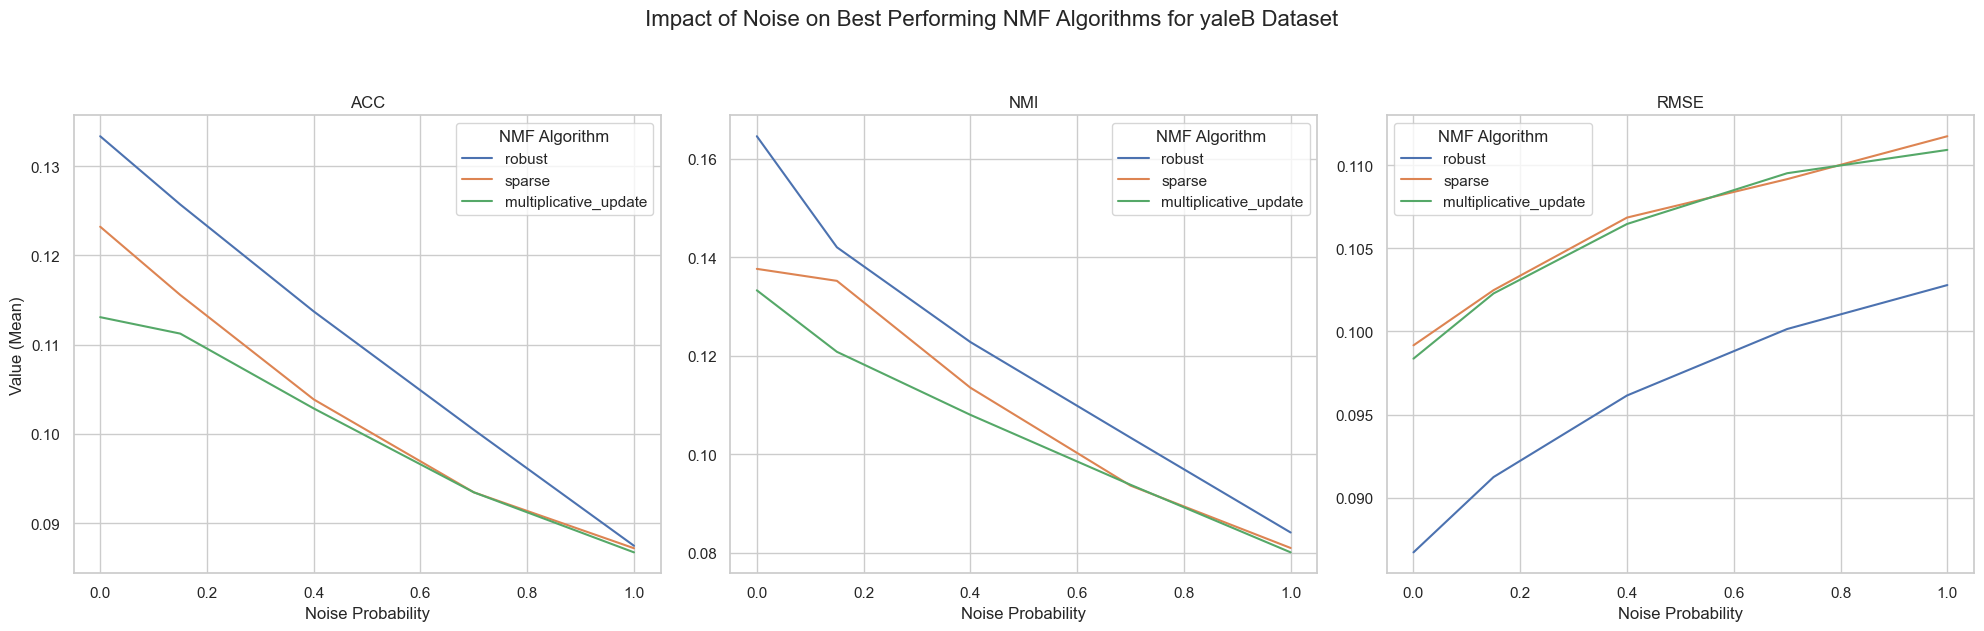

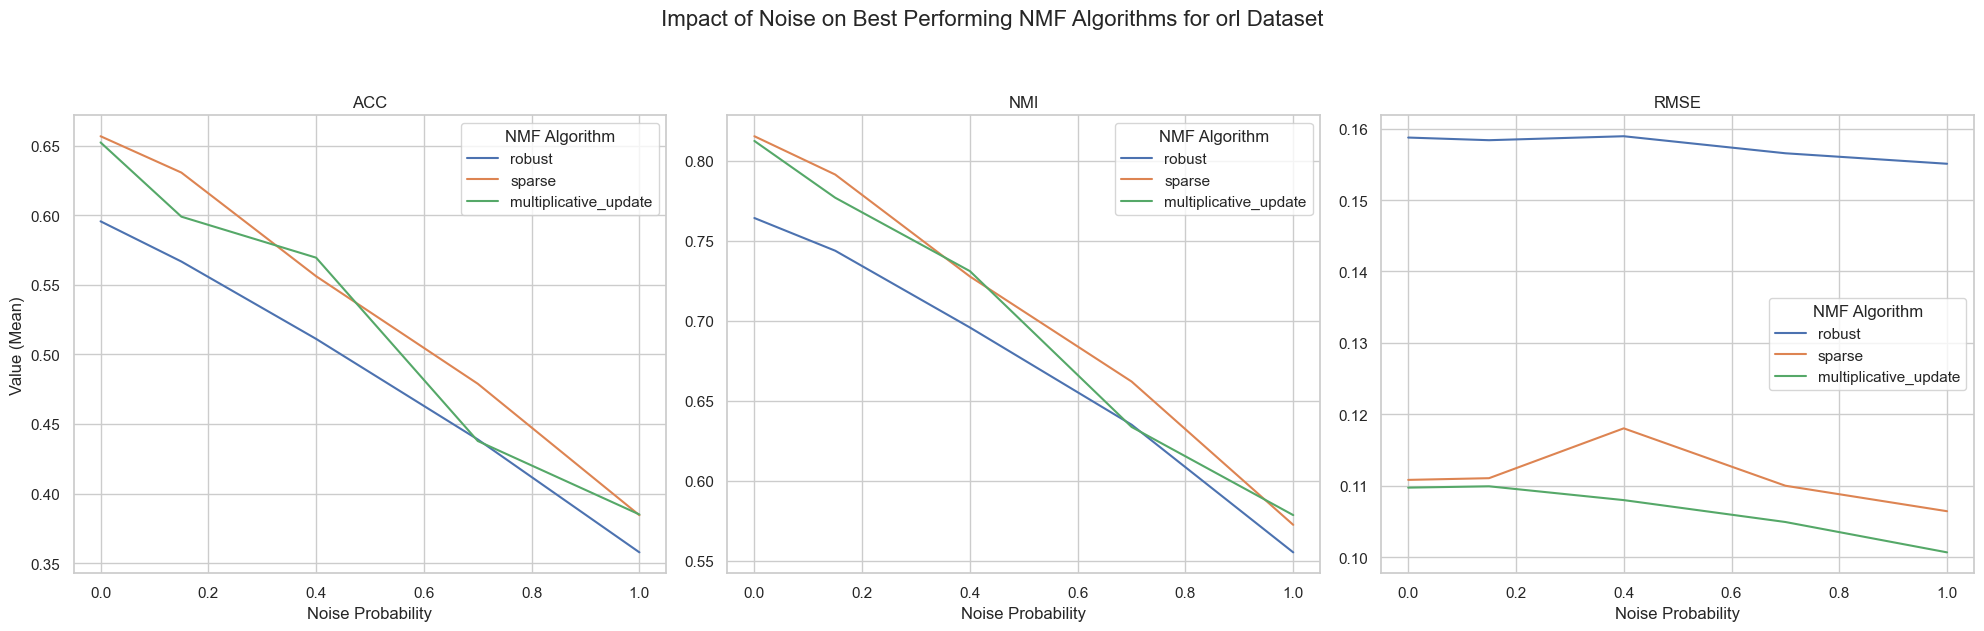

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the theme for the plots
sns.set_theme(style="whitegrid")

# For each dataset
for ds in ['yaleB', 'orl']:
    subset_df = result_df[result_df['dataset'] == ds]

   # Filter for the best ACC for Robust and Sparse NMF for each noise level
    best_performers = pd.DataFrame()
    for nmf_type in ['robust', 'sparse', 'multiplicative_update']:
        nmf_df = subset_df[subset_df['nmf'] == nmf_type]
        best_indices = nmf_df.groupby('noise_p').apply(lambda x: x['acc']['mean'].idxmax())
        best_rows = nmf_df.loc[best_indices]
        best_performers = pd.concat([best_performers, best_rows])
    best_performers

    # Set up the subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Impact of Noise on Best Performing NMF Algorithms for {ds} Dataset', fontsize=16, y=1.05)

    metrics = ['acc', 'nmi', 'rmse']
    for idx, metric in enumerate(metrics):
        sns.lineplot(x=('noise_p', ''), y=(metric, 'mean'), hue='nmf', data=best_performers, markers=True, ax=axs[idx])
        axs[idx].set_title(f'{metric.upper()}')
        axs[idx].set_xlabel('Noise Probability')
        if idx == 0:
            axs[idx].set_ylabel('Value (Mean)')
        else:
            axs[idx].set_ylabel('')
        axs[idx].legend(title='NMF Algorithm')

    plt.tight_layout()
    plt.show()


### Line Plot to Visualize the Effect of Hyperparameters

#### Robust NMF
For the Robust NMF, the hyperparameter of interest is Lambda. Our results show a variety of performance outcomes as Lambda values change across different noise levels.

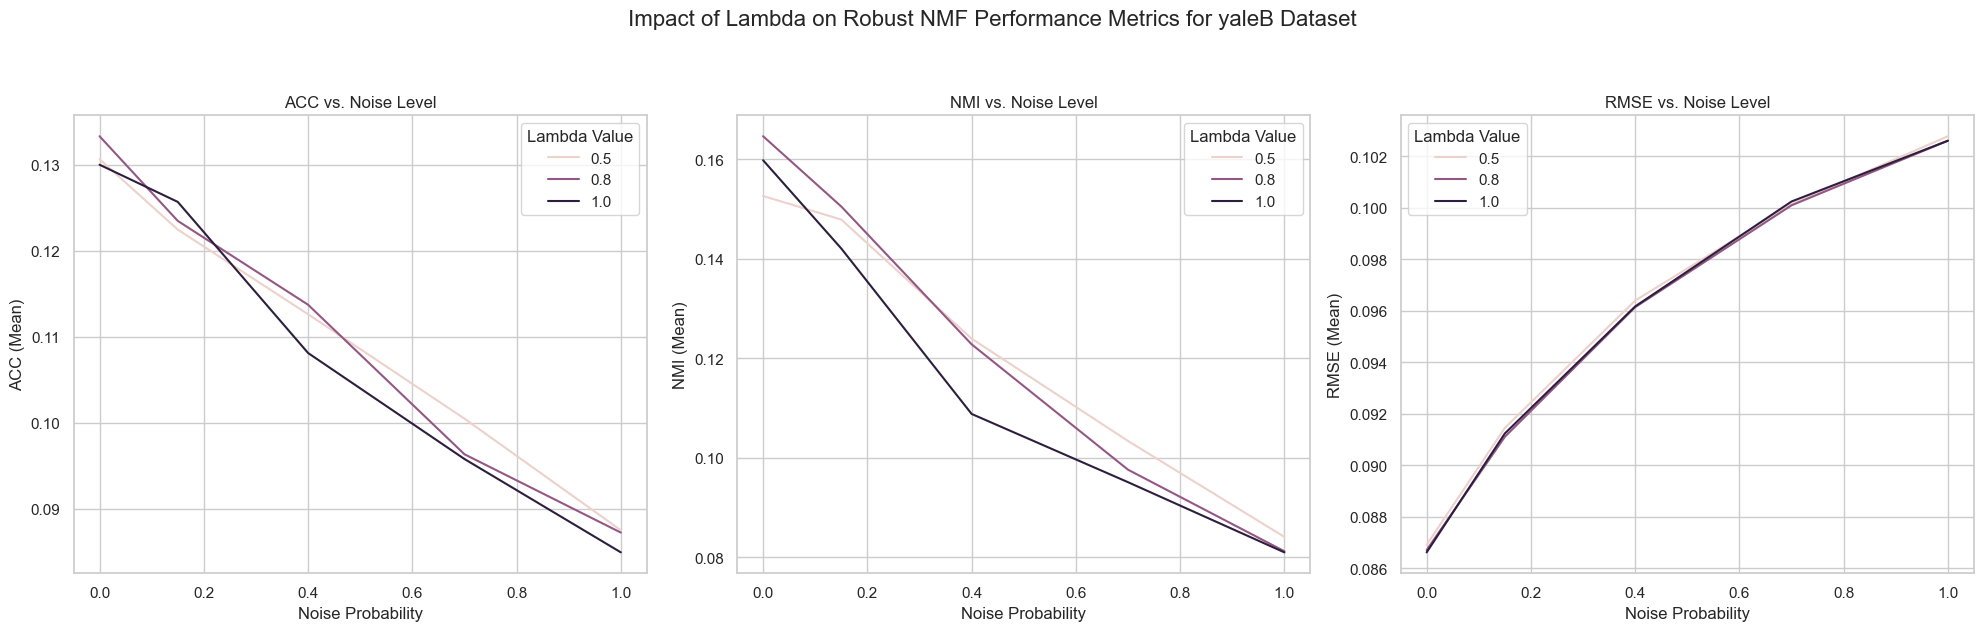

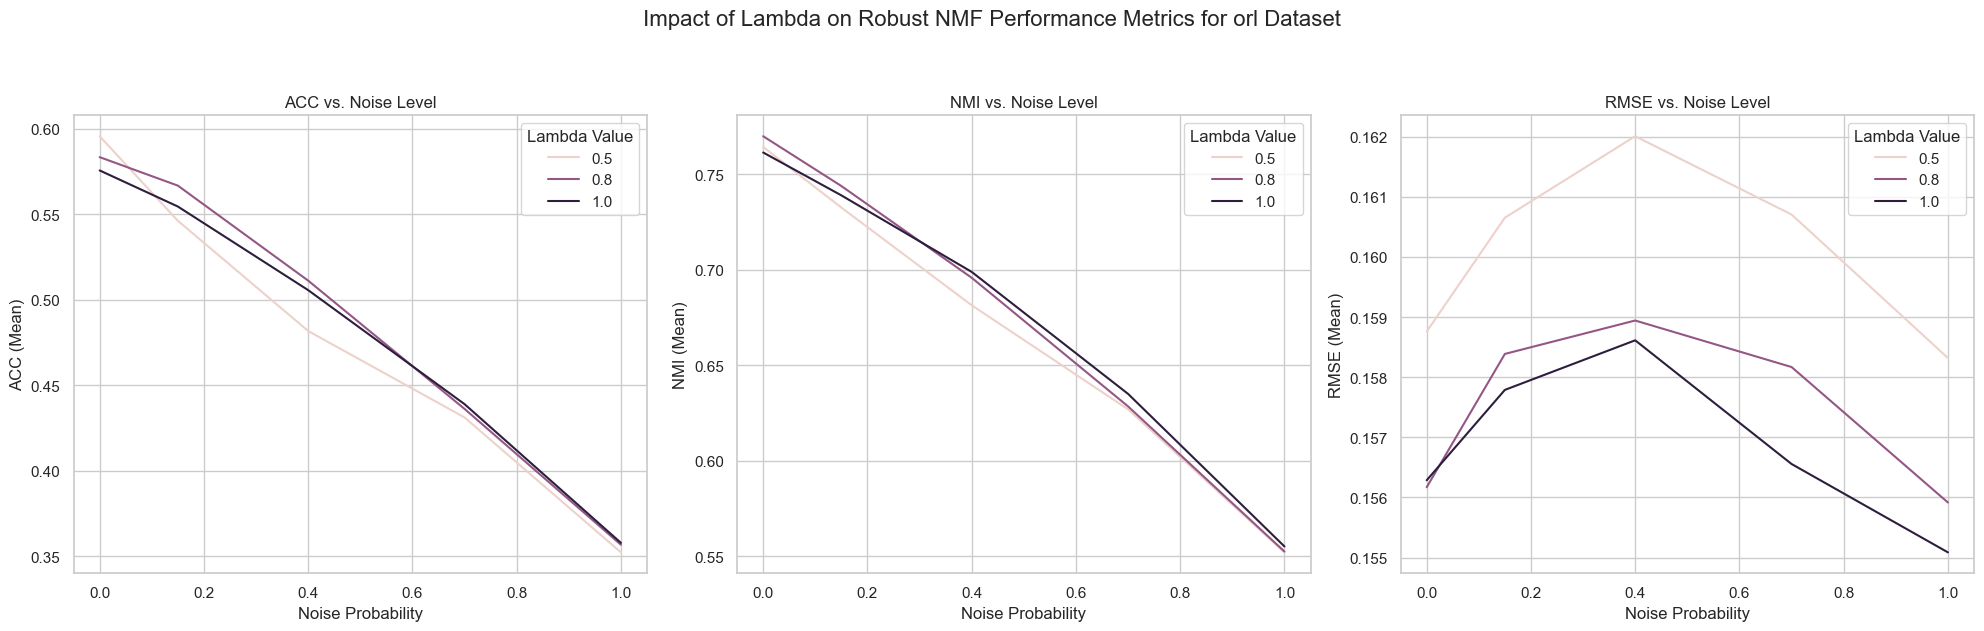

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

datasets = ['yaleB', 'orl']

# Filter data for Robust NMF
robust_df = result_df[result_df['nmf'] == 'robust']

for ds in datasets:
    # Filter data for specific dataset
    ds_robust_df = robust_df[robust_df['dataset'] == ds]

    # Set up the subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Impact of Lambda on Robust NMF Performance Metrics for {ds} Dataset', fontsize=16, y=1.05)

    metrics = ['acc', 'nmi', 'rmse']
    for idx, metric in enumerate(metrics):
        sns.lineplot(x='noise_p', y=(metric, 'mean'), hue='lambda', data=ds_robust_df, markers=True, ax=axs[idx])
        axs[idx].set_title(f'{metric.upper()} vs. Noise Level')
        axs[idx].set_xlabel('Noise Probability')
        axs[idx].set_ylabel(f'{metric.upper()} (Mean)')
        axs[idx].legend(title='Lambda Value')

    plt.tight_layout()
    plt.show()


#### Sparse NMF
For Sparse NMF, the hyperparameters of interest are Alpha and Beta. Their combined effect provides a rich performance landscape, which we've visualized below.

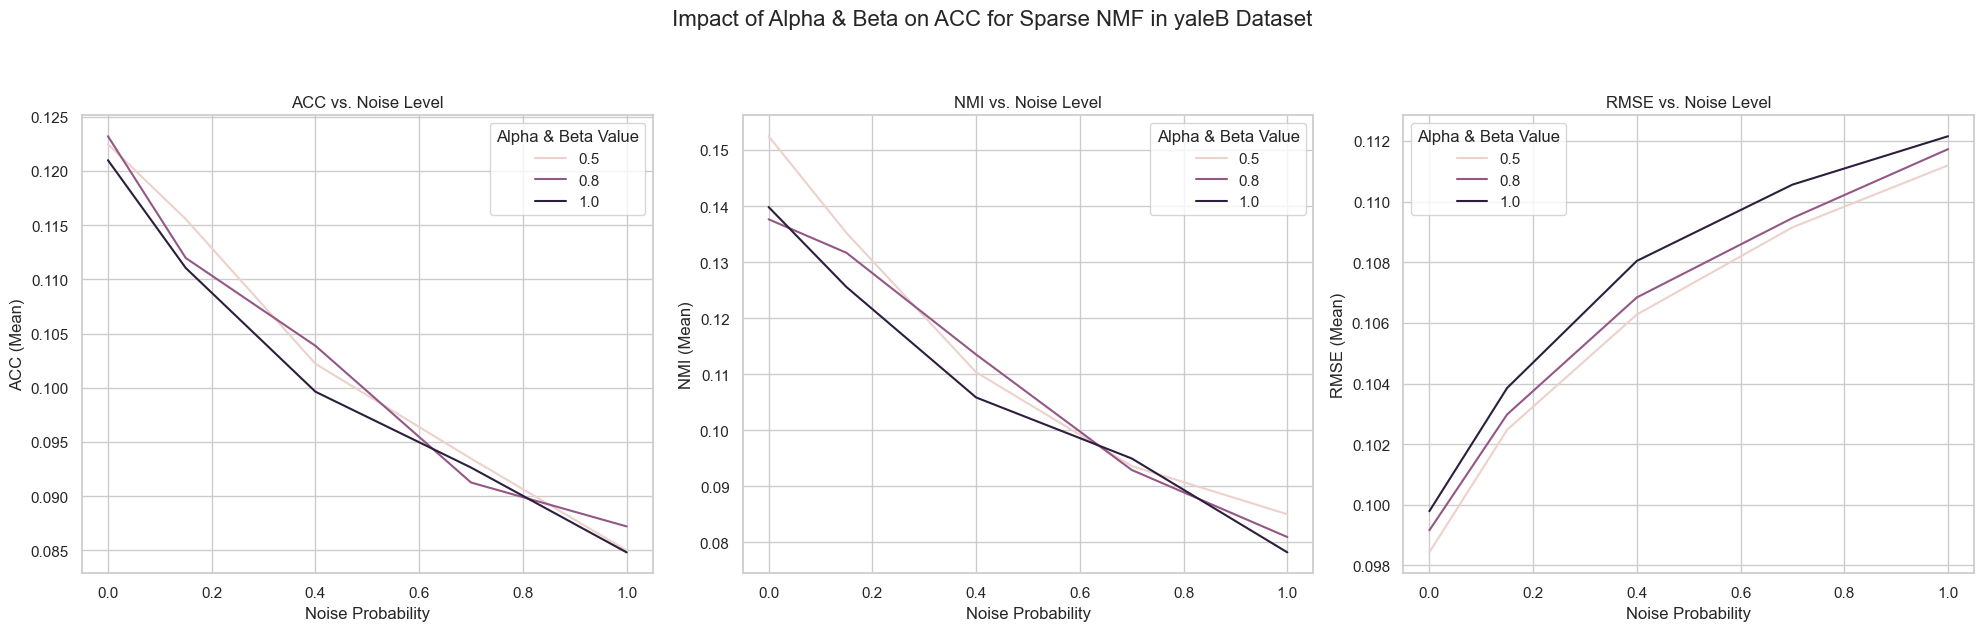

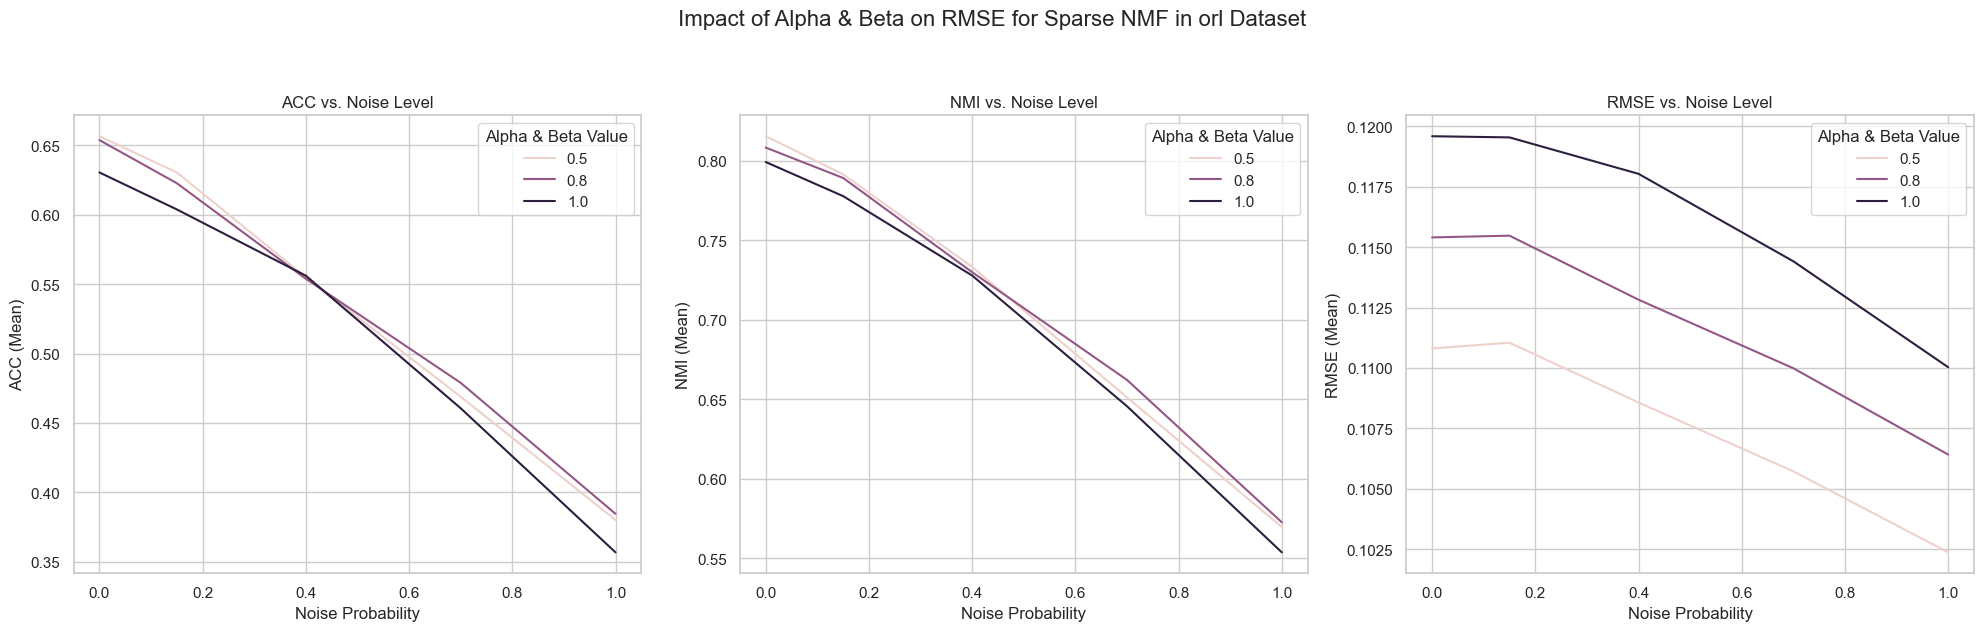

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

datasets = ['yaleB', 'orl']

# Filter data for Sparse NMF
sparse_df = result_df[result_df['nmf'] == 'sparse']

for ds in datasets:
    # Filter data for specific dataset
    ds_sparse_df = sparse_df[sparse_df['dataset'] == ds]

    # Set up the subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Impact of Alpha & Beta on {metric.upper()} for Sparse NMF in {ds} Dataset', fontsize=16, y=1.05)

    metrics = ['acc', 'nmi', 'rmse']
    for idx, metric in enumerate(metrics):
        sns.lineplot(x='noise_p', y=(metric, 'mean'), hue='alpha', data=ds_sparse_df, markers=True, ax=axs[idx])
        axs[idx].set_title(f'{metric.upper()} vs. Noise Level')
        axs[idx].set_xlabel('Noise Probability')
        axs[idx].set_ylabel(f'{metric.upper()} (Mean)')
        axs[idx].legend(title='Alpha & Beta Value')

    plt.tight_layout()
    plt.show()
    
    